In [2]:
# FFNN for Toy data
# Segessenmann J. 2020

import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

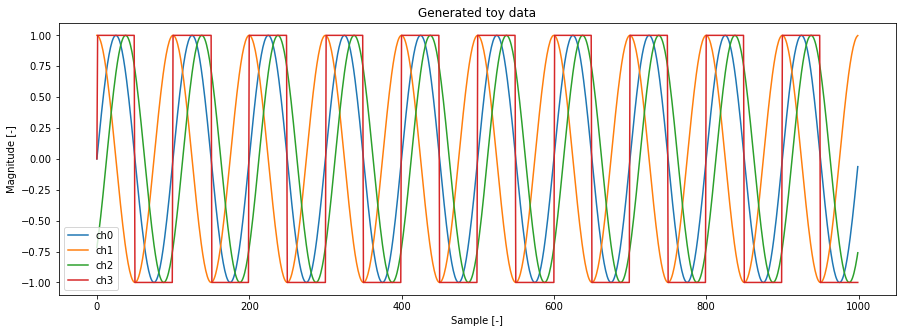

In [3]:
N_samples = 1000
N_turns = 10
x0 = np.sin(np.arange(0, N_turns*2*np.pi, N_turns*2*np.pi/N_samples))
x1 = np.cos(np.arange(0, N_turns*2*np.pi, N_turns*2*np.pi/N_samples))
x2 = np.sin(np.arange(-0.8, N_turns*2*np.pi-0.8, N_turns*2*np.pi/N_samples))
x3 = x0.copy()
x3[x3 > 0] = 1
x3[x3 < 0] = -1
data = np.array([x0, x1, x2, x3]).transpose()
plt.figure(figsize=(15,5))
plt.title('Generated toy data')
plt.plot(data[:,:])
plt.xlabel('Sample [-]'), plt.ylabel('Magnitude [-]')
plt.legend(['ch0', 'ch1', 'ch2', 'ch3'])
plt.savefig('fig_0422_toy_data.png')

# to tensor
data = torch.FloatTensor(data)

# split data
train_portion = 0.8
train_set = data[:int(train_portion * N_samples), :]
test_set = data[int(train_portion * N_samples):, :]

In [139]:
class FFNN(nn.Module):
    def __init__(self, channels_in: list, channel_size=4, hidden_size=2, recurrence=0.0):
        super().__init__()
        # Parameters
        self.hidden_size = hidden_size
        self.channel_size = channel_size
        self.full_size = channel_size + hidden_size
        # Create FC Layer
        self.W = nn.Linear(self.full_size, self.hidden_size)
        self.U = nn.Linear(self.full_size, self.channel_size)
        # Create gate
        self.s = torch.ones(self.channel_size, dtype=torch.float32)
        self.s[:3] = 0
        self.s2 = torch.ones(self.channel_size, dtype=torch.float32)
        self.s2[channels_in] = recurrence

    def forward(self, X):
        # Initialize hidden node
        r = torch.zeros(self.full_size, dtype=torch.float32)
        # Forward path
        for i in range(X.shape[0]):
            hidden = self.W(r)
            visible = torch.mul(self.s2, self.U(r)) + torch.mul((1-self.s2), X[i,:])
            u = torch.cat((visible, hidden), 0)
            r = torch.tanh(u)
        return r[3:4] #r[:self.channel_size], 

In [106]:
# prepare data for learning
window_size = 50
ch_in = [0, 1, 2]
ch_out = [3]
X_train, Y_train, X_test, Y_test = [], [], [], []
for i in range(train_set.shape[0] - window_size):
    X_train.append(train_set[i:i+window_size, :])
    Y_train.append(train_set[i+window_size-1, ch_out])
for i in range(test_set.shape[0] - window_size):
    X_test.append(test_set[i:i+window_size, :])
    Y_test.append(test_set[i+window_size-1, ch_out])

In [140]:
model = FFNN(ch_in)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

temp_loss = []
epoch_loss = []

start_time = time.time()

for epoch in range(epochs):
    for idx, X in enumerate(X_train):
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y_train[idx]) #[ch_out]
        loss.backward()
        optimizer.step()
        temp_loss.append(loss.item())

    epoch_loss.append(np.mean(np.asarray(temp_loss)))
    print(f'Epoch: {epoch} Loss: {epoch_loss[epoch]}')


total_time = time.time() - start_time
print('Time used [s]: ' + str(total_time))

Epoch: 0 Loss: 0.56723851197958
Epoch: 1 Loss: 0.3492586379192459
Epoch: 2 Loss: 0.2553444754608338
Epoch: 3 Loss: 0.20460290502024386
Epoch: 4 Loss: 0.17277933022278788
Epoch: 5 Loss: 0.15088579974828947
Epoch: 6 Loss: 0.1348593620755852
Epoch: 7 Loss: 0.12259542800981156
Epoch: 8 Loss: 0.11289302556048467
Epoch: 9 Loss: 0.10501566803346261
Time used [s]: 77.4250762462616


W: tensor([[ 0.9567,  0.6564,  0.0330,  0.1617,  0.6010, -0.0727],
        [-0.7724, -0.1599, -0.0310, -0.1322, -0.6352,  0.0900]])
U: tensor([[ 0.1457,  0.1484,  0.1247, -0.1038,  0.1406, -0.2248],
        [ 0.0491,  0.3992, -0.3943,  0.3692,  0.1645, -0.2128],
        [ 0.0491, -0.2530,  0.3914,  0.2786, -0.2846,  0.0034],
        [ 1.0166,  0.2854, -0.0244,  0.7115,  1.2486, -0.6958]])


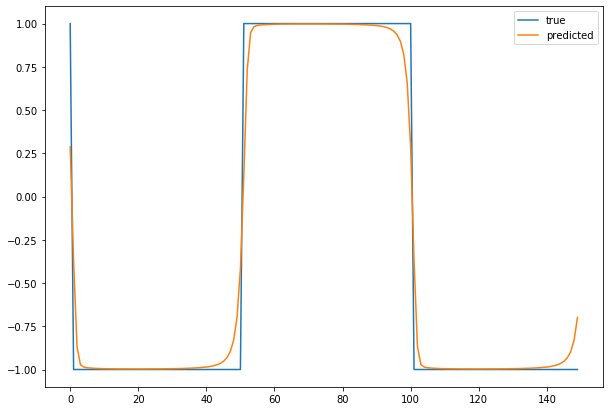

In [141]:
model.eval()

Y_preds = []
for idx, X in enumerate(X_test):
    with torch.no_grad():
        Y_preds.append(model(X).numpy())

preds = np.asarray(Y_preds)
Y_test_np = np.asarray([idx.numpy() for idx in Y_test])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(Y_test_np[:,0], label='true')
ax.plot(preds[:,0], label='predicted')
ax.legend()
fig.savefig('fig_0422_result_1-rotation.png')

print('W: ' + str(model.W.weight.data))
print('U: ' + str(model.U.weight.data))

In [125]:
model = FFNN(ch_in)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

In [126]:
y, y_old = model(X_train[0])

In [128]:
print(y[3:4])
print(y_old)

tensor([0.2272], grad_fn=<SliceBackward>)
tensor([0.2272], grad_fn=<SliceBackward>)
